In [127]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: imblearn in c:\users\iabd12\appdata\local\programs\python\python312\lib\site-packages (0.0)




[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [128]:
import kagglehub
import shutil
import os

dataset_path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")
current_dir = os.getcwd()  

for filename in os.listdir(dataset_path):
    file_path = os.path.join(dataset_path, filename)
    shutil.move(file_path, current_dir)

print(f"¡Dataset descargado en: {current_dir}")
print("Archivos:", os.listdir(current_dir ))


¡Dataset descargado en: c:\Users\IABD12\Documents\GitHub\ClaseIABD\PIA\Prueba Grupal
Archivos: ['a.ipynb', 'diabetes_012_health_indicators_BRFSS2015.csv', 'diabetes_binario_2015.csv', 'diabetes_binary_5050split_health_indicators_BRFSS2015.csv']


Estas columnas son ideales para modelos como XGBoost o Gradient Boosting, donde puedes explotar relaciones no lineales o jerárquicas:

BMI (Continuous)

Descripción: Índice de Masa Corporal (valor numérico continuo).

Importante: Factor clave para diabetes y enfermedades metabólicas.

GenHlth (Ordinal: 1-5)

Descripción: Autoevaluación de salud general:

1 = Excelente, 2 = Muy buena, 3 = Buena, 4 = Regular, 5 = Mala.

Uso: Relación subjetiva pero potente con condiciones crónicas.

MentHlth (Continuous: 0-30)

Descripción: Días de mala salud mental en los últimos 30 días.

Nota: Valores altos pueden correlacionar con estrés crónico (impacta diabetes).

PhysHlth (Continuous: 0-30)

Descripción: Días de mala salud física en los últimos 30 días.

Ejemplo: Dolor crónico o limitaciones físicas.

Age (Ordinal: 1-13)

Descripción: Grupos de edad codificados:

1 = 18-24 años, 2 = 25-29, ..., 13 = 80+ años.

Relevancia: La edad es un predictor fuerte de diabetes tipo 2.

Education (Ordinal: 1-6)

Descripción: Nivel educativo:

1 = Sin educación formal, 6 = Universitario o superior.

Contexto: Menor educación puede asociarse a menos acceso a salud preventiva.

Income (Ordinal: 1-8)

Descripción: Rango de ingresos anuales:

1 = <10,000,‘8‘ => 10,000,‘8‘=>75,000.

Uso: Socioeconomía afecta acceso a alimentación saludable y ejercicio.

## Gradient Boosting (Alejandro Cruz)

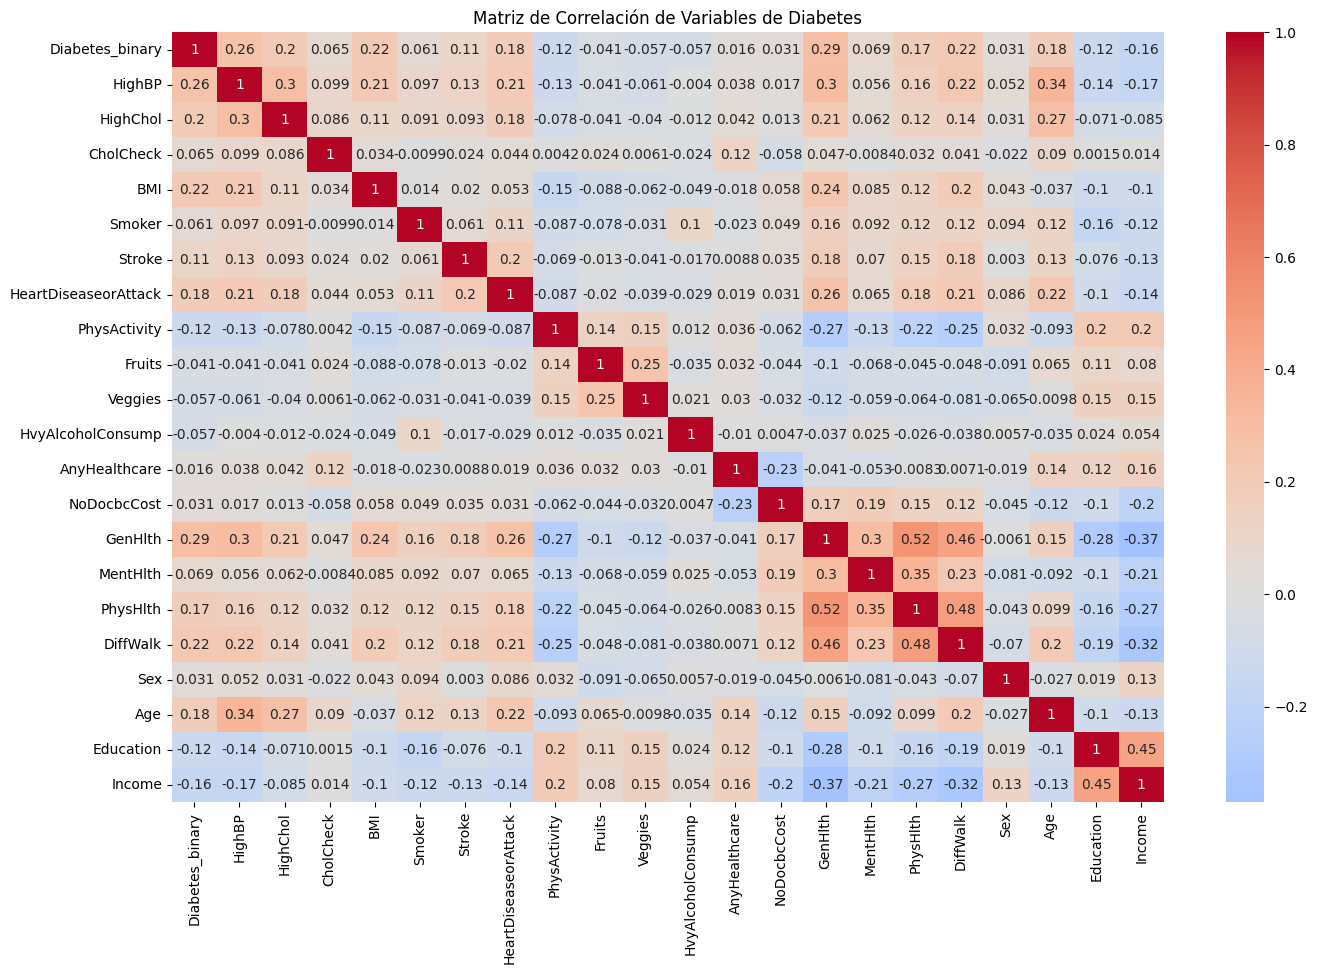

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('diabetes_binario_2015.csv')

correlation_matrix = data.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación de Variables de Diabetes')
plt.show()

### Limpieza de datos de las columnas menos relevantes

In [130]:
low_corr_vars = [
    'Stroke', 'MentHlth', 'CholCheck', 'Smoker', 'NoDocbcCost', 
    'Sex', 'AnyHealthcare', 'Fruits', 'Veggies', 'HvyAlcoholConsump'
]
data_clean = data.drop(columns=low_corr_vars)
print(data_clean.isnull().sum())
data_clean = data_clean.dropna()

Diabetes_binary         0
HighBP                  0
HighChol                0
BMI                     0
HeartDiseaseorAttack    0
PhysActivity            0
GenHlth                 0
PhysHlth                0
DiffWalk                0
Age                     0
Education               0
Income                  0
dtype: int64


### One Hot Encoding de los datos + Escalado


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

num_vars = ['BMI', 'Age', 'PhysHlth', 'HighBP', 'GenHlth', 'DiffWalk', 'HighChol']
data_clean[num_vars] = scaler.fit_transform(data_clean[num_vars])

data_clean = pd.get_dummies(data_clean, columns=['Education', 'Income'], drop_first=True)

### Aplicamos SMOTE si el desbalance de los datos es demasiado grande

In [132]:
from imblearn.over_sampling import SMOTE

X = data_clean.drop('Diabetes_binary', axis=1)
y = data_clean['Diabetes_binary']

# Aplicar SMOTE solo si el desbalance es significativo
if y.value_counts()[0] / len(y) > 0.7:  
    X, y = SMOTE().fit_resample(X, y)
    data_clean = pd.concat([X, y], axis=1)

### Eliminar datos extremos del BMI. (Si son muy altos o muy bajos directamente deberian estar muertos por otras cosas)

In [133]:
# Para BMI (evitar valores extremos)
Q1 = data_clean['BMI'].quantile(0.05)
Q3 = data_clean['BMI'].quantile(0.95)
data_clean = data_clean[(data_clean['BMI'] >= Q1) & (data_clean['BMI'] <= Q3)]

### Comprobacion de los datasets

In [134]:
print(f"Dataset original: {data.shape}")
print(f"Dataset limpio: {data_clean.shape}")
print("\nVariables finales:", list(data_clean.columns))

Dataset original: (253680, 22)
Dataset limpio: (399351, 22)

Variables finales: ['HighBP', 'HighChol', 'BMI', 'HeartDiseaseorAttack', 'PhysActivity', 'GenHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Education_2.0', 'Education_3.0', 'Education_4.0', 'Education_5.0', 'Education_6.0', 'Income_2.0', 'Income_3.0', 'Income_4.0', 'Income_5.0', 'Income_6.0', 'Income_7.0', 'Income_8.0', 'Diabetes_binary']


## Entrenamientos de los datos

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = data.drop('Diabetes_binary', axis=1)
y = data['Diabetes_binary']

X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X, y, test_size=0.2, random_state=38)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_B)
X_test_scaled = scaler.transform(X_test_B)

## GradientBoostingClassifier (Problematico a más no poder)

Accuracy: 0.8608

Matriz de Confusión Optimizada:


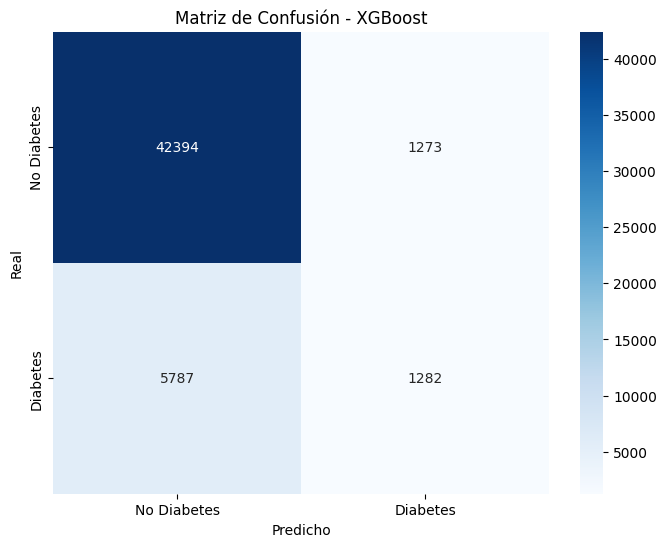


Reporte de Clasificación Mejorado:
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     43667
         1.0       0.50      0.18      0.27      7069

    accuracy                           0.86     50736
   macro avg       0.69      0.58      0.59     50736
weighted avg       0.83      0.86      0.83     50736



In [212]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

gb_model = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=1,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    subsample=0.7,
    random_state=38
)

gb_model.fit(
    X_train_B, 
    y_train_B,
)

y_pred_B_1 = gb_model.predict(X_test_B)

print(f"Accuracy: {accuracy_score(y_test_B, y_pred_B_1):.4f}")
print("\nMatriz de Confusión Optimizada:")

cm = confusion_matrix(y_test_B, y_pred_B_1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Matriz de Confusión - XGBoost')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

print("\nReporte de Clasificación Mejorado:")
print(classification_report(y_test_B, y_pred_B_1))

## XGBoost (El bueno)

[0]	validation_0-logloss:0.66761
[10]	validation_0-logloss:0.56183
[20]	validation_0-logloss:0.53467
[30]	validation_0-logloss:0.52453
[40]	validation_0-logloss:0.52099
[50]	validation_0-logloss:0.51952
[60]	validation_0-logloss:0.51863
[70]	validation_0-logloss:0.51805
[80]	validation_0-logloss:0.51790
[90]	validation_0-logloss:0.51773
[100]	validation_0-logloss:0.51726
[110]	validation_0-logloss:0.51737
[120]	validation_0-logloss:0.51715
[130]	validation_0-logloss:0.51715
[140]	validation_0-logloss:0.51685
[150]	validation_0-logloss:0.51656
[160]	validation_0-logloss:0.51668
[170]	validation_0-logloss:0.51679
[180]	validation_0-logloss:0.51652
[190]	validation_0-logloss:0.51639
[199]	validation_0-logloss:0.51654
📊 Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.95      0.70      0.81     43667
         1.0       0.30      0.79      0.44      7069

    accuracy                           0.72     50736
   macro avg       0.63      0

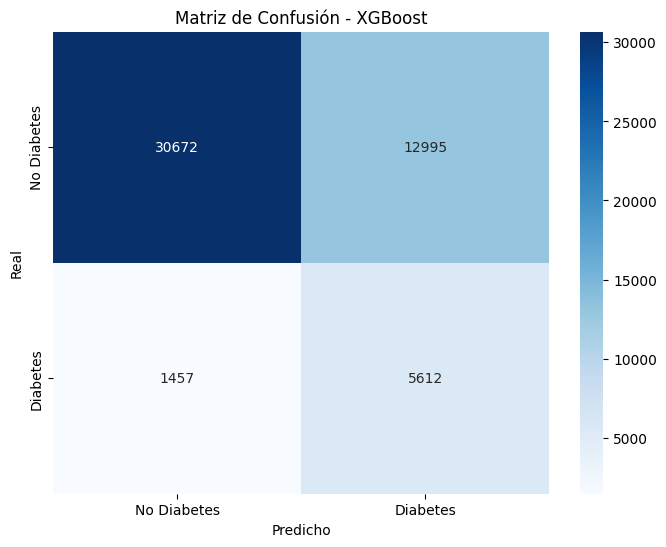

In [211]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    scale_pos_weight=len(y_train_B[y_train_B==0]) / len(y_train_B[y_train_B==1]),
    random_state=38,
    eval_metric='logloss'
)

model.fit(
    X_train_B, 
    y_train_B,
    eval_set=[(X_test_B, y_test_B)],
    verbose=10
)

y_pred_B_2 = model.predict(X_test_B)

print("📊 Reporte de Clasificación:")
print(classification_report(y_test_B, y_pred_B_2))

cm = confusion_matrix(y_test_B, y_pred_B_2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Matriz de Confusión - XGBoost')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()


## Regresión Lineal y Polinómica(Álvaro Prado)

Importacion de librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

Carga de datos y limpieza del dataset

In [139]:
# Cargar el archivo CSV
file_path = "diabetes_binario_2015.csv"
df = pd.read_csv(file_path)

# Convertir todas las columnas a tipo numérico
df = df.apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores nulos
df_clean = df.dropna()

# Eliminar duplicados
df_clean = df_clean.drop_duplicates()


Selección de variables y división de datos

In [140]:
# Seleccionar las variables
X = df_clean[['BMI']].values  # Variable independiente
y = df_clean['Diabetes_binary'].values  # Variable dependiente

# Dividir en conjunto de entrenamiento y prueba
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X, y, test_size=0.2, random_state=42)


Regresión Lineal

In [141]:
# Regresión Lineal
lin_reg = LinearRegression()
lin_reg.fit(X_train_A, y_train_A)
y_pred_lin = lin_reg.predict(X_test_A)


Regresión Polinómica (grado 2)

In [142]:
# Regresión Polinómica (grado 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train_A)
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y_train_A)
X_test_poly = poly.transform(X_test_A)
y_pred_poly = poly_reg.predict(X_test_poly)


Evaluacion de modelos

In [143]:
# ---- Evaluación de modelos de regresión ----
mse_lin = mean_squared_error(y_test_A, y_pred_lin)
rmse_lin = np.sqrt(mse_lin)
mae_lin = mean_absolute_error(y_test_A, y_pred_lin)
r2_lin = r2_score(y_test_A, y_pred_lin)

mse_poly = mean_squared_error(y_test_A, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
mae_poly = mean_absolute_error(y_test_A, y_pred_poly)
r2_poly = r2_score(y_test_A, y_pred_poly)

# ---- Modelo de Gradient Boosting ----
gb_model = GradientBoostingClassifier(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
gb_model.fit(X_train_A, y_train_A, sample_weight=np.where(y_train_A == 1, 3, 1))  # Mayor peso a clase 1

# Predicciones en el conjunto de prueba
y_pred_gb = gb_model.predict(X_test_A)

# ---- Evaluación del modelo de clasificación ----
accuracy = accuracy_score(y_test_A, y_pred_gb)
conf_matrix = confusion_matrix(y_test_A, y_pred_gb)
class_report = classification_report(y_test_A, y_pred_gb)

# ---- Formato de salida requerido ----
print(f"Exactitud del Gradient Boosting: {accuracy:.4f}\n")
print("Matriz de Confusión:")
print(conf_matrix, "\n")
print("Reporte de Clasificación:")
print(class_report)

# ---- Evaluación detallada de regresión ----
print("\nMétricas de Regresión Lineal:")
print(f"MSE: {mse_lin:.4f}")
print(f"RMSE: {rmse_lin:.4f}")
print(f"MAE: {mae_lin:.4f}")
print(f"R²: {r2_lin:.4f}")

print("\nMétricas de Regresión Polinómica (Grado 2):")
print(f"MSE: {mse_poly:.4f}")
print(f"RMSE: {rmse_poly:.4f}")
print(f"MAE: {mae_poly:.4f}")
print(f"R²: {r2_poly:.4f}")

Exactitud del Gradient Boosting: 0.7893

Matriz de Confusión:
[[34235  4578]
 [ 5093  1989]] 

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88     38813
         1.0       0.30      0.28      0.29      7082

    accuracy                           0.79     45895
   macro avg       0.59      0.58      0.58     45895
weighted avg       0.78      0.79      0.79     45895


Métricas de Regresión Lineal:
MSE: 0.1251
RMSE: 0.3537
MAE: 0.2484
R²: 0.0415

Métricas de Regresión Polinómica (Grado 2):
MSE: 0.1241
RMSE: 0.3523
MAE: 0.2470
R²: 0.0488


 Visualización de resultados

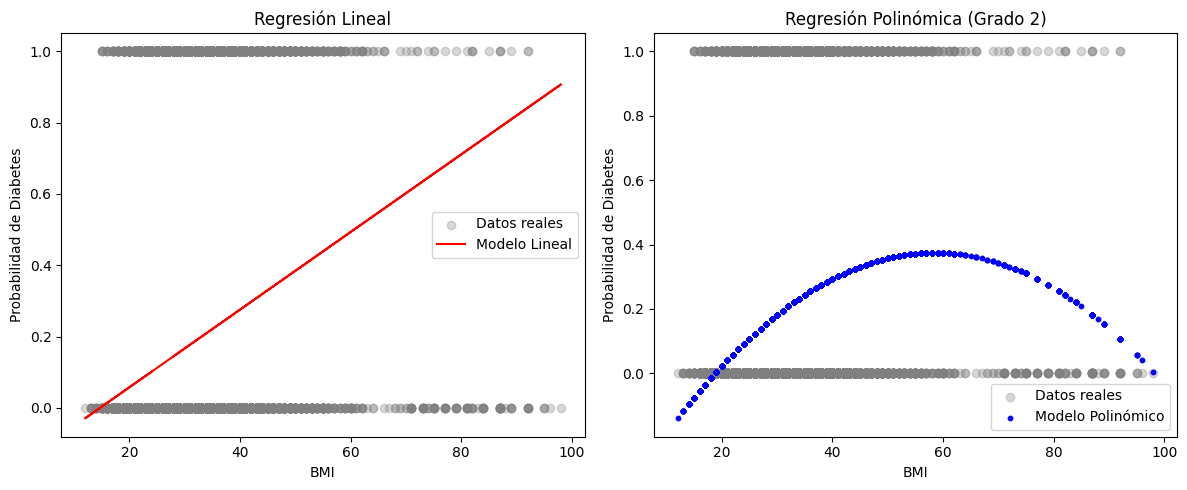

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1️⃣ Gráfico de la regresión lineal
ax[0].scatter(X_test_A, y_test_A, color="gray", alpha=0.3, label="Datos reales")
ax[0].plot(X_test_A, y_pred_lin, color="red", label="Modelo Lineal")
ax[0].set_title("Regresión Lineal")
ax[0].set_xlabel("BMI")
ax[0].set_ylabel("Probabilidad de Diabetes")
ax[0].legend()

# 2️⃣ Gráfico de la regresión polinómica
ax[1].scatter(X_test_A, y_test_A, color="gray", alpha=0.3, label="Datos reales")
ax[1].scatter(X_test_A, y_pred_poly, color="blue", s=10, label="Modelo Polinómico")
ax[1].set_title("Regresión Polinómica (Grado 2)")
ax[1].set_xlabel("BMI")
ax[1].set_ylabel("Probabilidad de Diabetes")
ax[1].legend()

plt.tight_layout()
plt.show()

## KNN (Miguel Sedano) 

1. Importación de librerías

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
# Cargar el dataset
df = pd.read_csv("diabetes_binario_2015.csv")


In [ ]:
# Verificar valores nulos
df.dropna(inplace=True)

In [ ]:
# Separar características y variable objetivo
X = df.drop(columns=["Diabetes_binary"])
y = df["Diabetes_binary"]

In [ ]:
# Selección de características más relevantes
selector = SelectKBest(score_func=f_classif, k=10)  # Seleccionamos las 10 mejores características
X = selector.fit_transform(X, y)
# Dividir en conjunto de entrenamiento y prueba
X_train_M, X_test_M, y_train_M, y_test_M = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [180]:
# Aplicar ADASYN para balancear las clases
adasyn = ADASYN(random_state=42)
X_train_M, y_train_M = adasyn.fit_resample(X_train_M, y_train_M)


In [ ]:

# Normalizar los datos
scaler = StandardScaler()
X_train_M = scaler.fit_transform(X_train_M)
X_test_M = scaler.transform(X_test_M)

In [ ]:
# Aplicar KNN con diferentes valores de K
k_values = range(3, 16)
accuracy_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan', weights='distance', n_jobs=-1)
    knn.fit(X_train_M, y_train_M)
    y_pred_M = knn.predict(X_test_M)
    accuracy_scores.append(accuracy_score(y_test_M, y_pred_M))

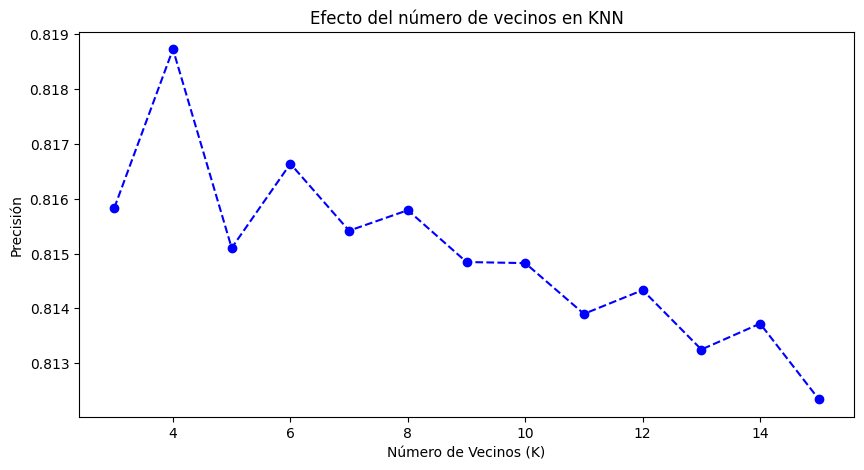

In [ ]:
# Graficar la precisión en función de K
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='dashed', color='b')
plt.xlabel('Número de Vecinos (K)')
plt.ylabel('Precisión')
plt.title('Efecto del número de vecinos en KNN')
plt.show()

In [ ]:
# Selección del mejor K basado en la precisión máxima
best_k = k_values[np.argmax(accuracy_scores)]
print(f"Mejor valor de K: {best_k}")

Mejor valor de K: 4


In [ ]:
# Entrenar modelo con el mejor K
knn_best = KNeighborsClassifier(n_neighbors=best_k, metric='manhattan', weights='distance')
knn_best.fit(X_train_M, y_train_M)
y_pred_best = knn_best.predict(X_test_M)

In [ ]:
# Evaluación del modelo
print("Matriz de Confusión:")
print(confusion_matrix(y_test_M, y_pred_best))

print("\nReporte de Clasificación:")
print(classification_report(y_test_M, y_pred_best))

Matriz de Confusión:
[[39284  4383]
 [ 4814  2255]]

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90     43667
         1.0       0.34      0.32      0.33      7069

    accuracy                           0.82     50736
   macro avg       0.62      0.61      0.61     50736
weighted avg       0.81      0.82      0.82     50736

